In [ ]:
# workflow for the visualisation and data analsysis
import sys
sys.path.append('..')
import torch
import pandas as pd
from internal_utils import get_CIFAR10_dataloader, \
    get_teacher_model, get_learner_model, preprocess_images,\
        add_random_noise_batch, blur_image_batch, \
            compute_distance_between_images, compute_sparseness_of_heatmap
from experiments.evaluation_functions import perform_lrp_plain, perform_gradcam
from experiments import WrapperNet
# Load data
# generate the blurred images, noisy images, and the ground truth heatmap images
# then for each, calculate the distance between the heatmaps over the blurred images and the ground truth heatmap images
def are_any_nan(list_of_tensors):
    for tensor in list_of_tensors:
        if torch.isnan(tensor).any():
            return True
    return False

def process_batch(
    input_batch:torch.Tensor, 
    input_labels:torch.Tensor,  
    methods: list, 
    kernel_size_min: float, 
    kernel_size_max:float, 
    noise_level_min: float, 
    noise_level_max: float):
    """Process the batch of images.

    Args:
        model (torch.nn.Module): model to be visualised
        methods (list): list of methods(functions) to be used on each datapoint of form (name, method, model)
        kernel_size (int): size of the Gaussian kernel
        noise_level (float): level of noise to be added
    Returns:
        dict: dictionary of distances between the heatmaps
    """
    results_dictionary = {}
    for name, method, model in methods:
        # get the ground truth heatmap using the method
        ground_truth_heatmap = method(input_batch, input_labels, model)
        assert not torch.isnan(ground_truth_heatmap).any(), f"Found NaN in ground truth heatmap: {name}"
        # treat various images to get the noisy and blurred images
        # run preprecoessing on the images --- normalise them to be within the right range
        noisy_images_small = preprocess_images(add_random_noise_batch(input_batch, noise_level_min))
        noisy_images_large = preprocess_images(add_random_noise_batch(input_batch, noise_level_max))
        blurred_images_small = preprocess_images(blur_image_batch(input_batch, kernel_size_min))
        blurred_images_large = preprocess_images(blur_image_batch(input_batch, kernel_size_max))
        # generate the new heatmaps for each
        assert not are_any_nan([ground_truth_heatmap, noisy_images_small, noisy_images_large, blurred_images_small, blurred_images_large]), f"Found NaN in preprocessed images: {name}"
        noisy_heatmaps_small = method(noisy_images_small, input_labels, model)
        noisy_heatmaps_large = method(noisy_images_large, input_labels, model)
        blurred_heatmaps_small = method(blurred_images_small, input_labels, model)
        blurred_heatmaps_large = method(blurred_images_large, input_labels, model)
        # calculate the distance between the heatmaps
        assert not are_any_nan([ground_truth_heatmap, noisy_heatmaps_small, noisy_heatmaps_large, blurred_heatmaps_small, blurred_heatmaps_large]), f"Found NaN in heatmaps: {name}"
        distance_noise_small = compute_distance_between_images(ground_truth_heatmap, noisy_heatmaps_small)
        distance_noise_large = compute_distance_between_images(ground_truth_heatmap, noisy_heatmaps_large)
        distance_blur_small = compute_distance_between_images(ground_truth_heatmap, blurred_heatmaps_small)
        distance_blur_large = compute_distance_between_images(ground_truth_heatmap, blurred_heatmaps_large)
        assert not are_any_nan([distance_noise_small, distance_noise_large, distance_blur_small, distance_blur_large]), f"Found NaN in distances: {name}"
        # calculate sparseness of heatmap
        sparseness_original, sparseness_gini = compute_sparseness_of_heatmap(ground_truth_heatmap)
        assert not are_any_nan([sparseness_original, sparseness_gini]), f"Found NaN in sparseness: {name}"
        # store the results in the dictionary
        results_dictionary[f"{name}_distance_noise_small"] = distance_noise_small
        results_dictionary[f"{name}_distance_noise_large"] = distance_noise_large
        results_dictionary[f"{name}_distance_blur_small"] = distance_blur_small
        results_dictionary[f"{name}_distance_blur_large"] = distance_blur_large
        results_dictionary[f"{name}_sparseness_original"] = sparseness_original
        results_dictionary[f"{name}_sparseness_gini"] = sparseness_gini
    # return data
    return results_dictionary

    
def main():
    # define params
    kernel_size_min = 3
    kernel_size_max = 5
    noise_level_min = 0.1
    noise_level_max = 0.3
    # get the data
    data_loader = get_CIFAR10_dataloader()
    # get the model
    learner_model = get_learner_model()
    teacher_model = get_teacher_model()
    # define the methods
    methods = [
        ("LRP", perform_lrp_plain, WrapperNet(teacher_model, hybrid_loss=True)),
        # ("LossLRP", perform_lrp_plain, WrapperNet(learner_model, hybrid_loss=True)),
        ("GradCAM", perform_gradcam, teacher_model),
    ]
    # process the data
    table = {}
    for i, (input_batch, input_labels) in enumerate(data_loader):
    # for _ in range(0,3):
        # input_batch, input_labels = next(iter(data_loader))
        results = process_batch(
            input_batch, 
            input_labels, 
            methods, 
            kernel_size_min, 
            kernel_size_max, 
            noise_level_min, 
            noise_level_max
        )
        # print the results
        # print(f"Batch {i} results: {results}")
        for key, value in results.items():
            if key not in table.keys():
                table[key] = value.detach()
            else:
                table[key] = torch.cat([table[key], value.detach()], dim = 0)
    # convert to pandas dataframe
    df = pd.DataFrame(table)
    # save results
    # df.to_csv("test_results.csv")
    return df

In [ ]:
df = main()

In [ ]:
df.to_csv("data/test_results.csv")

In [ ]:
df.columns

In [28]:
LRP_results = [col for col in df.columns if "LRP" in col]
gradcam_results = [col for col in df.columns if "GradCAM" in col]
df_lrp = df[LRP_results]
df_gradcam = df[gradcam_results]

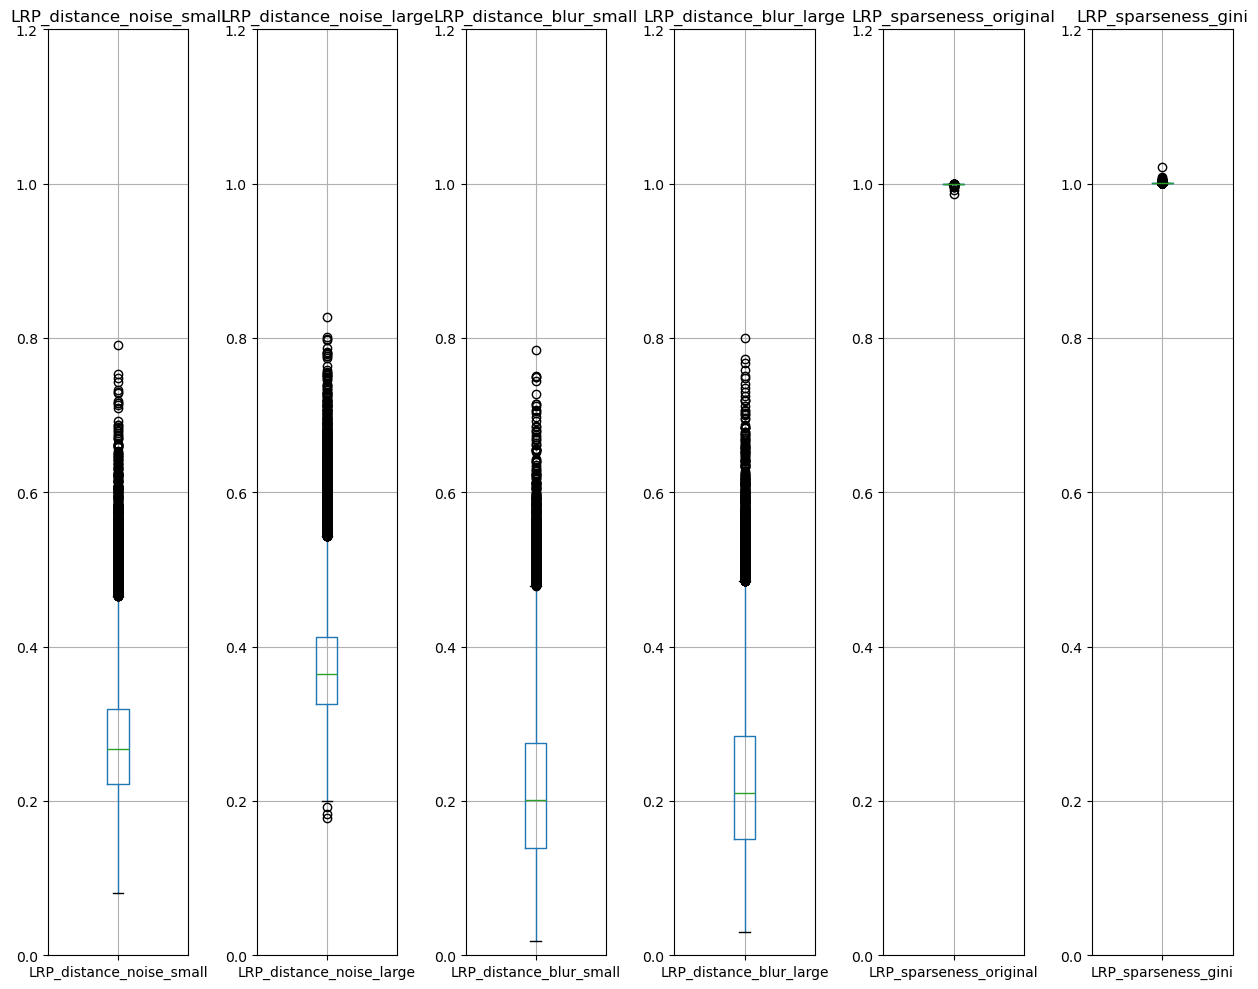

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25, 10))  # Adjust the size as needed
for i, column in enumerate(df_lrp.columns):
    plt.subplot(1, len(df.columns), i + 1)  # Creates a subplot for each column
    df_lrp.boxplot(column)
    plt.ylim(0, 1.2)
    plt.title(column)
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area
plt.show()

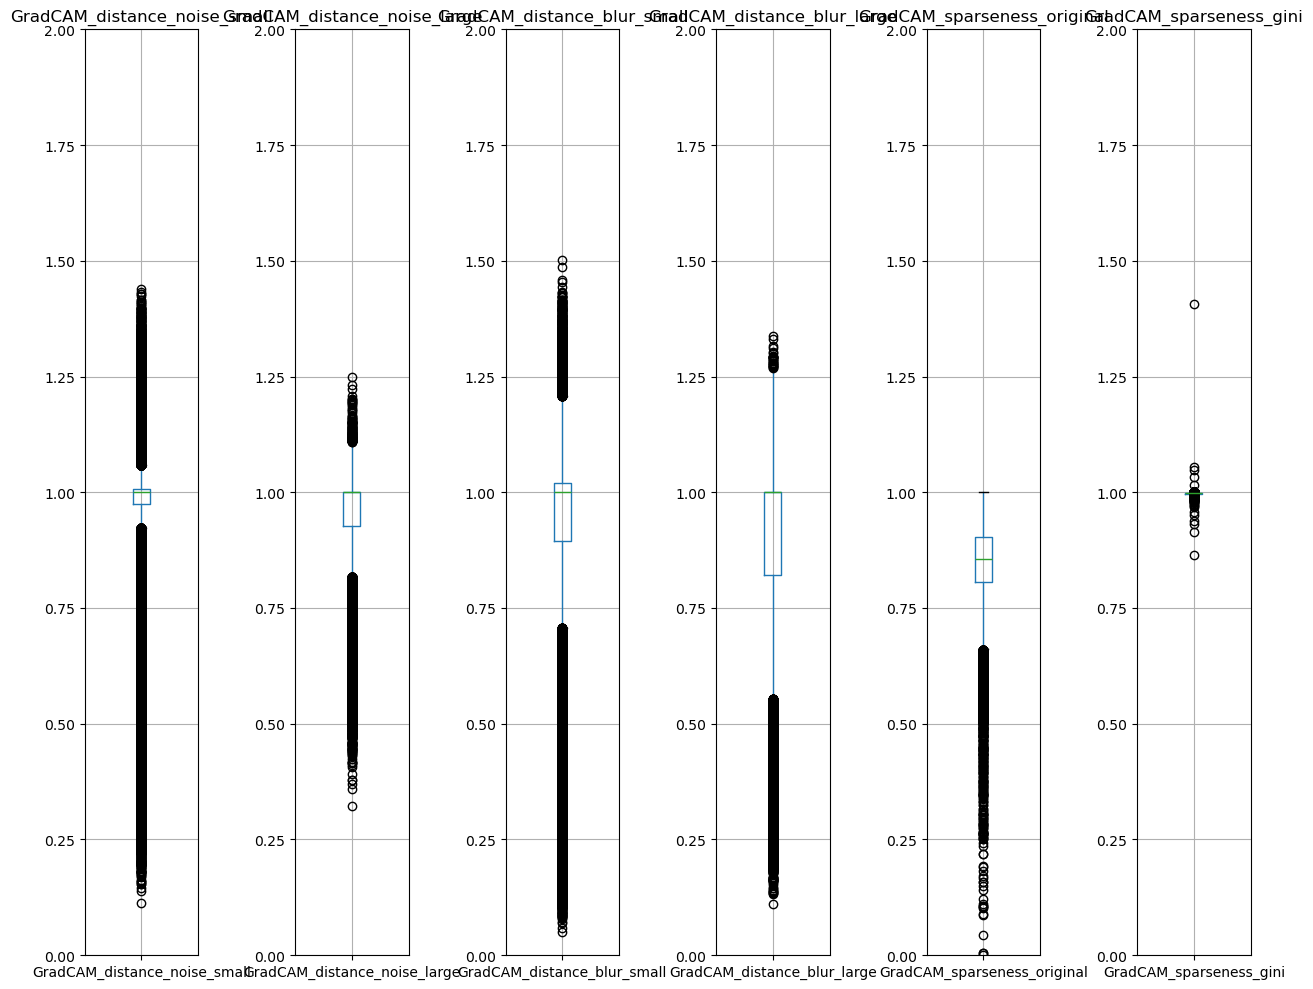

In [31]:
plt.figure(figsize=(25, 10))  # Adjust the size as needed
for i, column in enumerate(df_gradcam.columns):
    plt.subplot(1, len(df.columns), i + 1)  # Creates a subplot for each column
    df_gradcam.boxplot(column)
    plt.ylim(0, 2)
    plt.title(column)
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area
plt.show()